In [1]:
#pip install tweepy
#pip install tensorflow

SyntaxError: invalid syntax (170689579.py, line 1)

### Install All the required directories

In [88]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,LSTM,MultiHeadAttention,Input,Embedding,GlobalAveragePooling1D
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Load the "Data_For_Sentiment_Analysis" excel file in a data frame df

In [29]:


# Load the Excel file into a DataFrame
file_path = 'Data_For_Sentiment_Analysis.xlsx'
df = pd.read_excel(file_path)

# Show the first few rows of the DataFrame to understand its structure
df.head()


,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


### The dataset contains three columns:
<ol>
<li>File Name: The name of the file that contains the text ,It is a identifier for the row.</li>
<li>Caption: The text content, will be used for sentiment analysis.</li>
<li>LABEL: The sentiment label, which could be either of  1 value "positive," "negative," or "neutral."</li>
</ol>

In [76]:
df.shape

(4869, 3)

In [77]:
df.describe() ## This displays the summary statistics of the data.

,File Name,Caption,LABEL
count,4869,4869,4869
unique,4869,4663,3
top,1.txt,#February #Winter #Rainy #Stormy #Windy #Tuesd...,neutral
freq,1,10,1771


In [78]:
df.info() # There is no missing value.
          # Data type of date,WeekStatus,Day_of_week,Load_type is String, 
          # NSM is integer type and rest columns are Numerical Variables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4869 entries, 0 to 4868
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   File Name  4869 non-null   object
 1   Caption    4869 non-null   object
 2   LABEL      4869 non-null   object
dtypes: object(3)
memory usage: 114.2+ KB


In [79]:
# Check for missing values in the DataFrame
# missing_values = df.isnull().sum()
# missing_values
missing_val_df = pd.DataFrame().from_records([{'Column Name':col, 
                                               'Missing Values': len(df[df[col].isna()]), 
                                               'Missing Values (%)':np.round(len(df[df[col].isna()])/len(df), 4)*100}
                                              for col in df.columns])
print('Missing values before data cleaning')
missing_val_df

Missing values before data cleaning


,Column Name,Missing Values,Missing Values (%)
0,File Name,0,0.0
1,Caption,0,0.0
2,LABEL,0,0.0


In [31]:
# Check the distribution of the sentiment labels
label_distribution = df['LABEL'].value_counts()
label_distribution

neutral     1771
positive    1646
negative    1452
Name: LABEL, dtype: int64

As for the distribution of sentiment labels, we have:
<table><tr>
<th>Count</th>
<th>Label</th>
</tr></thead>
<tr>
<td>1771</td><td> Neutral</td>
</tr>
<tr>
<td>1646</td><td> Positive</td>
</tr>
<tr>
<td>1452</td><td> Negative</td>
</tr>
</table>
The classes are relatively balanced, which is good for model training.

### To preprocess the text data , below steps to be done:
<ol>
<li><b>Tokenization:</b> Convert each text into a sequence of integers.</li>
<li><b>Padding:</b> Make all sequences have the same length by padding shorter ones with zeros.</li>
<li><b>Label Encoding:</b> Convert the text labels ("positive," "neutral," "negative") into numerical form.</li>
</ol>

We will use TensorFlow's text preprocessing utilities for these tasks.

In [80]:
# Initialize the tokenizer with a specific vocabulary size and out-of-vocabulary token
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['Caption'])

In [81]:

# Convert each text into a sequence of integers
sequences = tokenizer.texts_to_sequences(df['Caption'])
# Check the length of a random sequence before padding
len_before_padding = len(sequences[42])

# Pad sequences to make them of the same length
padding_type = 'post'
trunc_type = 'post'
max_length = 100  # You can adjust this based on your specific needs
padded_sequences = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=max_length)

# Check the length of the same random sequence after padding
len_after_padding = len(padded_sequences[42])
len_before_padding, len_after_padding, padded_sequences[42]

(15,
 100,
 array([  55,   16,  134,   62,   16, 2236,    6, 1755,   13,  116,   10,
          30, 5437, 5438, 5439,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]))

### Split the data into training, validation, and test sets

In [85]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, numerical_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


### CNN for Text Classification
Convolutional Neural Networks (CNNs) are not just for image classification; they can also be used for text classification. 

Below is the sample article 
<a href="https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9">CNN for Text Classification</a>

In [90]:
# Initialize the CNN model
cnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# For example, to train the CNN model
history_cnn=cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 5s 36ms/step - loss: 1.0352 - accuracy: 0.4712 - val_loss: 0.9093 - val_accuracy: 0.5507
Epoch 2/10
 66/107 [=================>............] - ETA: 1s - loss: 0.5586 - accuracy: 0.8097

RNN for Text Classification
Recurrent Neural Networks (RNNs), specifically LSTMs or GRUs, are commonly used for text classification. Here's how you could build an RNN model:

In [57]:

# Initialize the RNN model
rnn_model = Sequential([
    Embedding(vocab_size, 128, input_length=max_length),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn= rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
107/107 [==============================] - 17s 123ms/step - loss: 1.0979 - accuracy: 0.3506 - val_loss: 1.0972 - val_accuracy: 0.3384
Epoch 2/10
107/107 [==============================] - 23s 219ms/step - loss: 1.0969 - accuracy: 0.3562 - val_loss: 1.0965 - val_accuracy: 0.3575
Epoch 3/10
107/107 [==============================] - 17s 156ms/step - loss: 1.0967 - accuracy: 0.3562 - val_loss: 1.0969 - val_accuracy: 0.3575
Epoch 4/10
107/107 [==============================] - 19s 177ms/step - loss: 1.0964 - accuracy: 0.3580 - val_loss: 1.0966 - val_accuracy: 0.3575
Epoch 5/10
107/107 [==============================] - 20s 183ms/step - loss: 1.0976 - accuracy: 0.3457 - val_loss: 1.0966 - val_accuracy: 0.3575
Epoch 6/10
107/107 [==============================] - 18s 171ms/step - loss: 1.0966 - accuracy: 0.3553 - val_loss: 1.0965 - val_accuracy: 0.3575
Epoch 7/10
107/107 [==============================] - 19s 175ms/step - loss: 1.0963 - accuracy: 0.3568 - val_loss: 1.0966 - val_ac

Transformer for Text Classification
The Transformer architecture has become the standard for many NLP tasks. You could use the Hugging Face Transformers library to use a pre-trained Transformer model, or build a simpler one from scratch. Here's a very simplified version:

python


In [60]:

# Define the input layer
input_layer = Input(shape=(max_length,))

# Embedding layer
embedding_layer = Embedding(vocab_size, 128)(input_layer)

# Multi-head self-attention layer
attention = MultiHeadAttention(num_heads=4, key_dim=128)(embedding_layer, embedding_layer, embedding_layer)

# Pooling layer to reduce sequence length
pooled_attention = GlobalAveragePooling1D()(attention)

# Fully-connected layer
dense_layer = Dense(64, activation='relu')(pooled_attention)

# Output layer
output_layer = Dense(3, activation='softmax')(dense_layer)

# Create the model
transformer_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
transformer_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_transformer=transformer_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
107/107 [==============================] - 31s 271ms/step - loss: 1.0978 - accuracy: 0.3316 - val_loss: 1.0946 - val_accuracy: 0.3575
Epoch 2/10
107/107 [==============================] - 32s 300ms/step - loss: 0.9511 - accuracy: 0.5029 - val_loss: 0.8734 - val_accuracy: 0.6123
Epoch 3/10
107/107 [==============================] - 31s 293ms/step - loss: 0.5200 - accuracy: 0.7785 - val_loss: 0.7308 - val_accuracy: 0.6904
Epoch 4/10
107/107 [==============================] - 33s 309ms/step - loss: 0.2942 - accuracy: 0.8859 - val_loss: 0.9502 - val_accuracy: 0.6932
Epoch 5/10
107/107 [==============================] - 35s 330ms/step - loss: 0.1274 - accuracy: 0.9528 - val_loss: 1.0743 - val_accuracy: 0.6986
Epoch 6/10
107/107 [==============================] - 41s 385ms/step - loss: 0.0663 - accuracy: 0.9771 - val_loss: 1.4283 - val_accuracy: 0.7000
Epoch 7/10
107/107 [==============================] - 45s 418ms/step - loss: 0.0438 - accuracy: 0.9862 - val_loss: 1.6621 - val_ac

In this example, we train the model for 10 epochs using a batch size of 32. The validation_data parameter allows us to specify a validation set that the model will be evaluated against after each epoch.

Monitoring Metrics
While training, it's essential to monitor several key metrics to understand how well the model is performing. These usually include:

Loss: Measures how well the model is doing, with lower values being better.
Accuracy: The proportion of correctly classified samples.
Evaluation Metrics and Testing
After training, you want to evaluate the model's performance on a separate test set that it has never seen before. Common metrics for classification problems like this include:

Accuracy: The percentage of correctly classified samples.
Precision, Recall, F1-Score: These metrics provide a more comprehensive view of how well your model is performing, especially if the classes are imbalanced.

In [51]:
# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(X_test, y_test)

# Optionally, you can use scikit-learn to calculate more detailed metrics

# Get the model predictions
y_pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# Calculate classification report
report = classification_report(y_test, y_pred)


23/23 [==============================] - 0s 6ms/step


In [52]:
# Evaluate the model on the test set
loss, accuracy = rnn_model.evaluate(X_test, y_test)

# Optionally, you can use scikit-learn to calculate more detailed metrics

# Get the model predictions
y_pred = np.argmax(rnn_model.predict(X_test), axis=-1)

# Calculate classification report
report = classification_report(y_test, y_pred)


23/23 [==============================] - 1s 28ms/step


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
# Evaluate the model on the test set
loss, accuracy = transformer_model.evaluate(X_test, y_test)

# Optionally, you can use scikit-learn to calculate more detailed metrics

# Get the model predictions
y_pred = np.argmax(transformer_model.predict(X_test), axis=-1)

# Calculate classification report
report = classification_report(y_test, y_pred)

23/23 [==============================] - 2s 61ms/step


visual representation often makes it easier to interpret the model's performance. Here are some common types of visualizations you can use:

1. Training and Validation Loss/Accuracy Curves
Plotting the training and validation loss and accuracy over each epoch can help you understand how well the model is learning. If the validation loss starts increasing while the training loss is decreasing, it's a sign of overfitting.

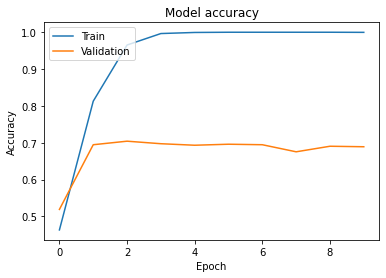

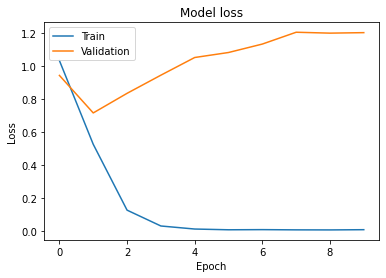

In [58]:


# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


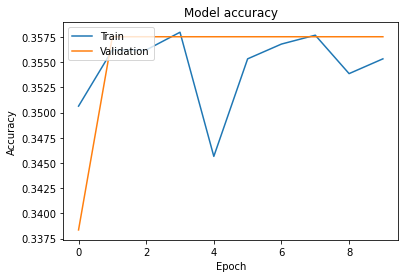

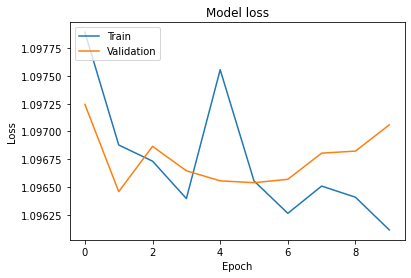

In [59]:


# Plot training & validation accuracy values
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


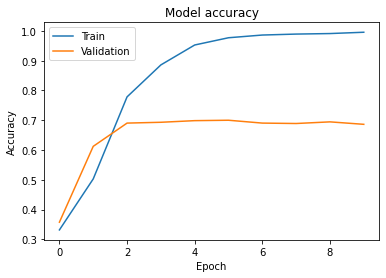

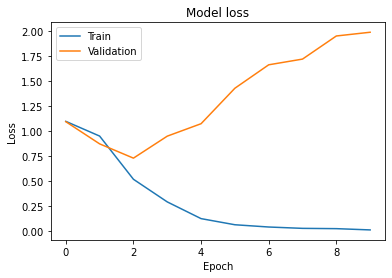

In [61]:


# Plot training & validation accuracy values
plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_transformer.history['loss'])
plt.plot(history_transformer.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Confusion Matrix
A confusion matrix gives a detailed breakdown of how the model's predictions compare to the actual labels. It's especially useful for multi-class classification problems.

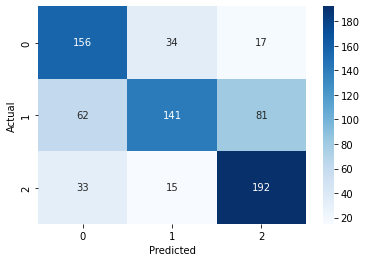

In [62]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Classification Report
While the classification report is often shown in a tabular format, you could also visualize it to make it more interpretable.

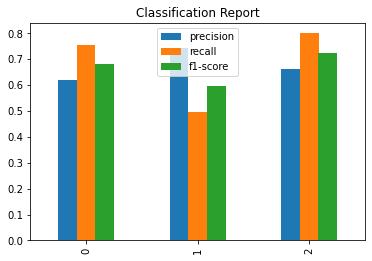

In [63]:
# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for easier visualization
report_df = pd.DataFrame(report).transpose()

# Plot as a bar chart
report_df[['precision','recall','f1-score']].drop(['accuracy','macro avg','weighted avg']).plot(kind='bar')
plt.title('Classification Report')
plt.show()


The ROC curve and AUC are generally defined for binary classification problems. For multi-class classification problems, you can create ROC curves and calculate AUC in one of the following ways:

One-vs-All (OvA) strategy: Compute the ROC curve and AUC for each class versus all other classes.
One-vs-One (OvO) strategy: Compute the ROC curve and AUC for each pair of classes. This method is usually computationally expensive for a large number of classes.
Micro- and Macro-averaging: Micro-averaging aggregates the contributions of all classes to compute the average metric, whereas Macro-averaging computes the metric independently for each class and then takes the average.

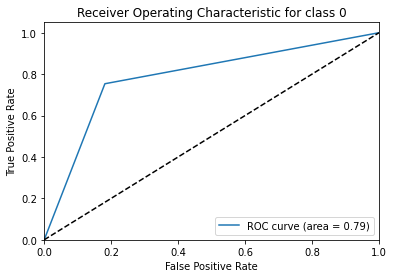

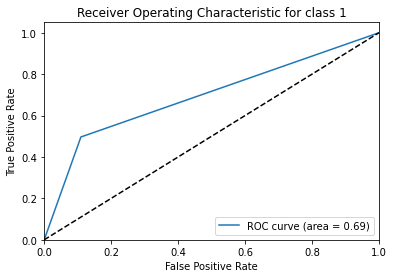

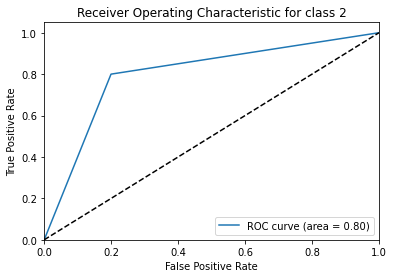

In [65]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


The ROC curve and AUC are generally defined for binary classification problems. For multi-class classification problems, you can create ROC curves and calculate AUC in one of the following ways:

One-vs-All (OvA) strategy: Compute the ROC curve and AUC for each class versus all other classes.
One-vs-One (OvO) strategy: Compute the ROC curve and AUC for each pair of classes. This method is usually computationally expensive for a large number of classes.
Micro- and Macro-averaging: Micro-averaging aggregates the contributions of all classes to compute the average metric, whereas Macro-averaging computes the metric independently for each class and then takes the average.
Here's how you can implement the OvA strategy:

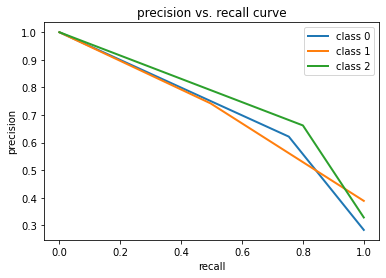

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute Precision-Recall and plot curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()


Word Embedding Visualization
If you're using an embedding layer in your neural networks, you can visualize the word vectors to see how words are grouped together in the embedding space.

In [68]:
# Save the embeddings
embeddings = cnn_model.layers[0].get_weights()[0]

# Use TensorBoard to visualize embeddings
from tensorflow.keras.callbacks import TensorBoard
import os

log_dir = os.path.join("logs", "embeddings")
tensorboard_callback = TensorBoard(log_dir=log_dir, embeddings_freq=1)

cnn_model.fit(X_train, y_train, epochs=10, callbacks=[tensorboard_callback])


Epoch 1/10
107/107 [==============================] - 3s 32ms/step - loss: 0.0039 - accuracy: 0.9994
Epoch 2/10
107/107 [==============================] - 4s 37ms/step - loss: 0.0047 - accuracy: 0.9991
Epoch 3/10
107/107 [==============================] - 5s 45ms/step - loss: 0.0039 - accuracy: 0.9991
Epoch 4/10
107/107 [==============================] - 4s 39ms/step - loss: 0.0036 - accuracy: 0.9994
Epoch 5/10
107/107 [==============================] - 4s 37ms/step - loss: 0.0050 - accuracy: 0.9991
Epoch 6/10
107/107 [==============================] - 5s 47ms/step - loss: 0.0034 - accuracy: 0.9994
Epoch 7/10
107/107 [==============================] - 5s 47ms/step - loss: 0.0045 - accuracy: 0.9991
Epoch 8/10
107/107 [==============================] - 6s 58ms/step - loss: 0.0030 - accuracy: 0.9994
Epoch 9/10
107/107 [==============================] - 5s 47ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 10/10
107/107 [==============================] - 5s 46ms/step - loss: 0.0038 - accura

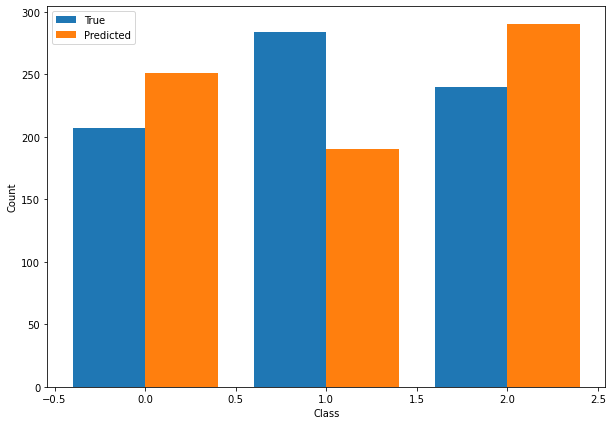

In [69]:
# Create a DataFrame with the true and predicted labels
df_predictions = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# Count the occurrences of each class
count_true = df_predictions['True'].value_counts().sort_index()
count_pred = df_predictions['Predicted'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(count_true.index - 0.2, count_true.values, 0.4, label='True')
plt.bar(count_pred.index + 0.2, count_pred.values, 0.4, label='Predicted')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.show()


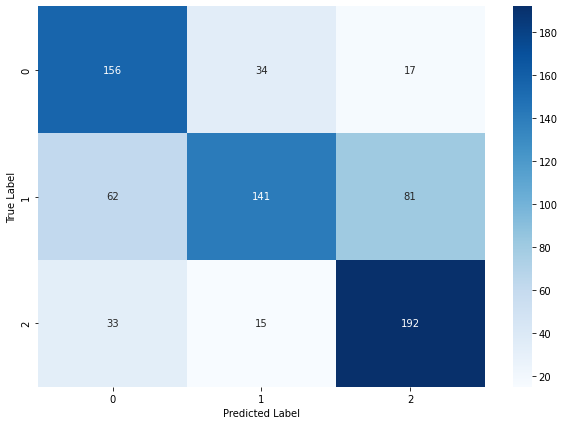

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


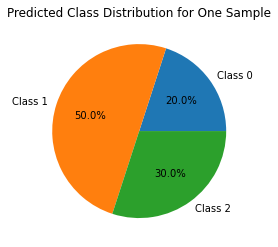

In [71]:
# Assuming pred_probs is an array of predicted probabilities for each class for one sample
pred_probs = np.array([0.2, 0.5, 0.3])

# Create a pie chart
labels = ['Class 0', 'Class 1', 'Class 2']
plt.pie(pred_probs, labels=labels, autopct='%1.1f%%')
plt.title('Predicted Class Distribution for One Sample')
plt.show()


In [72]:
# Convert to DataFrame for better visualization
df_comparison = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': y_pred
})

# Show the top 5 samples
df_comparison.head(50)


,True_Label,Predicted_Label
0,0,2
1,1,1
2,2,0
3,1,1
4,2,2
5,1,2
6,1,1
7,2,2
8,0,0
9,0,2
